In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_curve, roc_auc_score, auc
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

# 모델
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

In [2]:
warnings.filterwarnings("ignore")

In [3]:
from datetime import datetime
import pytz

def convert_milliseconds_to_new_york_time(milliseconds):
    # 밀리초를 초로 변환
    seconds = milliseconds / 1000

    # 뉴욕 시간대 객체 생성
    new_york_tz = pytz.timezone('America/New_York')

    # 밀리초로부터 날짜 계산
    input_date = datetime.fromtimestamp(seconds, tz=new_york_tz)

    return input_date

def get_today_date_in_new_york():
    # 뉴욕 시간대 객체 생성
    new_york_tz = pytz.timezone('America/New_York')

    # 현재 날짜를 뉴욕 시간대로 얻기
    today_date = datetime.now(tz=new_york_tz)

    return today_date

## 추가 데이터 

In [4]:
with open('extra_df.pickle', 'rb') as f:
  df_extra = pickle.load(f)

df_extra = df_extra[:90000]

In [5]:
with open('extra_df_2.pickle', 'rb') as f:
  df_extra_2 = pickle.load(f)

df_extra_2 = df_extra_2[:90000]

## 일부 컬럼만 가져옴

In [6]:
with open('master_num_1.pickle', 'rb') as f:
  df_extra_master_1 = pickle.load(f)

df_extra_master_1 = df_extra_master_1[:90000]

In [7]:
with open('master_num_2.pickle', 'rb') as f:
  df_extra_master_2 = pickle.load(f)

df_extra_master_2 = df_extra_master_2[:90000]

In [8]:
df_extra = pd.concat([df_extra, df_extra_master_1[['user_champion_num', 'champion_master_num']]], axis = 1)
df_extra_2 = pd.concat([df_extra_2, df_extra_master_1[['user_champion_num', 'champion_master_num']]], axis = 1)

## 이상처 처리

In [9]:
df_extra.loc[df_extra['user_champion_num'] > 162, 'user_champion_num'] = 162
df_extra.loc[df_extra['user_champion_num'] < 0, 'user_champion_num'] = 1

df_extra_2.loc[df_extra_2['user_champion_num'] > 162, 'user_champion_num'] = 162
df_extra_2.loc[df_extra_2['user_champion_num'] < 0, 'user_champion_num'] = 1

df_extra.loc[df_extra['champion_master_num'] < 0, 'champion_master_num'] = 0
df_extra.loc[df_extra['champion_master_num'] < 0.8, 'champion_master_num'] = 0
df_extra.loc[(0.8 <= df_extra['champion_master_num']) & (1 > df_extra['champion_master_num']), 'champion_master_num'] = 1

df_extra_2.loc[df_extra_2['champion_master_num'] < 0, 'champion_master_num'] = 0
df_extra_2.loc[df_extra_2['champion_master_num'] < 0.8, 'champion_master_num'] = 0
df_extra_2.loc[(0.8 <= df_extra_2['champion_master_num']) & (1 > df_extra_2['champion_master_num']), 'champion_master_num'] = 1

In [10]:
df_extra['champion_roll_num'] = df_extra['champion_roll_num'].round()
df_extra['tier_points'] = df_extra['tier_points'].round()
df_extra['play_num'] = df_extra['play_num'].round()
df_extra['league_points'] = df_extra['league_points'].round()
df_extra['summonerLevel'] = df_extra['summonerLevel'].round()
df_extra['user_champion_chest_granted_count'] = df_extra['user_champion_chest_granted_count'].round()
df_extra['days_diff'] = df_extra['days_diff'].round()
df_extra['champion_master_num'] = df_extra['champion_master_num'].round()
df_extra['user_champion_num'] = df_extra['user_champion_num'].round()


df_extra_2['champion_roll_num'] = df_extra_2['champion_roll_num'].round()
df_extra_2['tier_points'] = df_extra_2['tier_points'].round()
df_extra_2['play_num'] = df_extra_2['play_num'].round()
df_extra_2['league_points'] = df_extra_2['league_points'].round()
df_extra_2['summonerLevel'] = df_extra_2['summonerLevel'].round()
df_extra_2['user_champion_chest_granted_count'] = df_extra_2['user_champion_chest_granted_count'].round()
df_extra_2['days_diff'] = df_extra_2['days_diff'].round()
df_extra_2['champion_master_num'] = df_extra_2['champion_master_num'].round()
df_extra_2['user_champion_num'] = df_extra_2['user_champion_num'].round()

## 데이터 불러오기

In [11]:
with open('datas_practice_4.pickle', 'rb') as f:
  df_1 = pickle.load(f)

with open('datas_practice_merged_2_3_a.pickle', 'rb') as f:
    df_2 = pickle.load(f)
    
with open('datas_practice_5.pickle', 'rb') as f:
    df_3 = pickle.load(f)

In [12]:
with open('datas_roll_num.pickle', 'rb') as f:
    df_r = pickle.load(f)

In [13]:
datas_1 = df_2[:26625]
datas_2 = df_2[26625:]
datas_3 = df_1[:41895]

In [14]:
for i in range(0, len(datas_3)):
    datas_3[i]['user_cp_portion_assassin'] = round(1 - (datas_3[0]['user_cp_portion_tank'] + datas_3[0]['user_cp_portion_support'] + datas_3[0]['user_cp_portion_mage'] + datas_3[0]['user_cp_portion_fighter'] + datas_3[0]['user_cp_portion_marksman']), 2)

In [15]:
df_1

[{'user_name': '인생이란이런거지',
  'play_num': 16,
  'win_rate': 37.5,
  'veteran': False,
  'hot_streak': False,
  'freshblood': True,
  'league_points': 0,
  'summonerId': '97jdnpEQYg0QEwbOQEb3w6usZKaKvl1cWh5fpYPhq8JSis5v',
  'inactive': False,
  'tier': 'IRON',
  'revisionDate': 1694962668089,
  'summonerLevel': 56,
  'puuid': '7x1gvTaX2XdqR2ZWcj_ZMX2eGIH_Ys4FU4WxHyqIPHV2hznVrGIrg4-sqXa7O9MAYCA9lbaGl1hhDw',
  'champion_master_num': 1,
  'user_champion_num': 76,
  'user_champion_chest_granted_count': 4,
  'user_cp_portion_fighter': 0.34,
  'user_cp_portion_mage': 0.09,
  'user_cp_portion_marksman': 0.08,
  'user_cp_portion_support': 0.04,
  'user_cp_portion_tank': 0.11,
  'champion_roll_num': 3,
  'tier_points': 1,
  'user_cp_portion_assassin': 0.34},
 {'user_name': '냄비에데임',
  'play_num': 5,
  'win_rate': 40.0,
  'veteran': False,
  'hot_streak': False,
  'freshblood': False,
  'league_points': 15,
  'summonerId': 'rZaNOe7FTkeeVGVgXWow5b1KpElHuB0x5JLeq22fhqp6XDdE',
  'inactive': False,
  '

## roll_num 열만 붙여넣음

In [16]:
with open('datas_roll_num.pickle', 'rb') as file:
    datas = pickle.load(file)

In [17]:
datas = pd.DataFrame(datas)

## 날짜 계산

In [18]:
day_list = []

In [19]:
df_extra.loc[df_extra['days_diff'] <= 7, 'leave_game'] = 0
df_extra.loc[df_extra['days_diff'] > 7, 'leave_game'] = 1

In [20]:
df_extra_2.loc[df_extra_2['days_diff'] <= 7, 'leave_game'] = 0
df_extra_2.loc[df_extra_2['days_diff'] > 7, 'leave_game'] = 1

In [23]:
df_extra.loc[:, 'leave_game'].value_counts()

leave_game
0    65220
1    24780
Name: count, dtype: int64

In [24]:
df_extra_2.loc[:, 'leave_game'].value_counts()

leave_game
0    51337
1    38663
Name: count, dtype: int64

## 0915

In [25]:
# today_date_in_new_york = get_today_date_in_new_york() # 오늘 날짜(뉴욕 기준)

today_date_in_new_york = convert_milliseconds_to_new_york_time(1694793600000)

for i in range(0, len(datas_1)):
    
    time_newyork = convert_milliseconds_to_new_york_time(datas_1[i]['revisionDate'])

    diff_time = today_date_in_new_york - time_newyork    

    days_diff = diff_time.days
    
    datas_1[i]['days_diff'] = days_diff
    
    day_list.append(days_diff)
    
    if days_diff <= 7:
        datas_1[i]['leave_game'] = 0
    else: 
        datas_1[i]['leave_game'] = 1

## 0916

In [26]:
# today_date_in_new_york = get_today_date_in_new_york() # 오늘 날짜(뉴욕 기준)

today_date_in_new_york = convert_milliseconds_to_new_york_time(1694880000000)

for i in range(0, len(datas_2)):
    
    time_newyork = convert_milliseconds_to_new_york_time(datas_2[i]['revisionDate'])

    diff_time = today_date_in_new_york - time_newyork    

    days_diff = diff_time.days
    
    datas_2[i]['days_diff'] = days_diff
    
    day_list.append(days_diff)

    if days_diff <= 7:
        datas_2[i]['leave_game'] = 0
    else: 
        datas_2[i]['leave_game'] = 1

## 0922

In [27]:
# today_date_in_new_york = get_today_date_in_new_york() # 오늘 날짜(뉴욕 기준)

today_date_in_new_york = convert_milliseconds_to_new_york_time(1695398400000)

for i in range(0, len(datas_3)):
    
    time_newyork = convert_milliseconds_to_new_york_time(datas_3[i]['revisionDate'])

    diff_time = today_date_in_new_york - time_newyork    

    days_diff = diff_time.days
    
    datas_3[i]['days_diff'] = days_diff
    
    day_list.append(days_diff)

    if days_diff <= 7:
        datas_3[i]['leave_game'] = 0
    else: 
        datas_3[i]['leave_game'] = 1

In [28]:
for i in df_extra['days_diff']:
    day_list.append(i)

In [29]:
for i in df_extra_2['days_diff']:
    day_list.append(i)

## 지니 계수 함수

In [30]:
def calculate_gini(ratios):
    total = sum(ratios)
    squared_ratios = [ratio**2 for ratio in ratios]
    gini = 1 - sum(squared_ratios)
    return gini

## 데이터 병합

In [31]:
df_1 = pd.DataFrame(datas_1)
df_2 = pd.DataFrame(datas_2)
df_3 = pd.DataFrame(datas_3)

## 독립변수 설정

In [32]:
df_x_train_1 = df_1[['play_num', 'veteran', 'hot_streak', 'freshblood', 'league_points', 'tier_points', 'summonerLevel',
                 'user_champion_chest_granted_count', 'user_cp_portion_assassin', 
                     'user_cp_portion_fighter','user_cp_portion_mage', 'user_cp_portion_marksman','user_cp_portion_support', 'user_cp_portion_tank','champion_master_num',
       'user_champion_num']]

df_x_train_2 = df_2[['play_num', 'veteran', 'hot_streak', 'freshblood', 'league_points', 'tier_points', 'summonerLevel',
                 'user_champion_chest_granted_count', 'user_cp_portion_assassin', 
                     'user_cp_portion_fighter','user_cp_portion_mage', 'user_cp_portion_marksman','user_cp_portion_support', 'user_cp_portion_tank','champion_master_num',
       'user_champion_num']]

df_x_train_3 = df_3[['play_num', 'veteran', 'hot_streak', 'freshblood', 'league_points', 'tier_points', 'summonerLevel',
                 'user_champion_chest_granted_count', 'user_cp_portion_assassin', 
                     'user_cp_portion_fighter','user_cp_portion_mage', 'user_cp_portion_marksman','user_cp_portion_support', 'user_cp_portion_tank','champion_master_num',
       'user_champion_num']]

df_x_train_4 = df_extra[['play_num', 'veteran', 'hot_streak', 'freshblood', 'league_points', 'tier_points', 'summonerLevel',
                 'user_champion_chest_granted_count', 'user_cp_portion_assassin', 
                     'user_cp_portion_fighter','user_cp_portion_mage', 'user_cp_portion_marksman','user_cp_portion_support', 'user_cp_portion_tank','champion_master_num',
       'user_champion_num']]

df_x_train_5 = df_extra_2[['play_num', 'veteran', 'hot_streak', 'freshblood', 'league_points', 'tier_points', 'summonerLevel',
                 'user_champion_chest_granted_count', 'user_cp_portion_assassin', 
                     'user_cp_portion_fighter','user_cp_portion_mage', 'user_cp_portion_marksman','user_cp_portion_support', 'user_cp_portion_tank','champion_master_num',
       'user_champion_num']]

## 종속변수 설정

In [33]:
df_y_train_1 = df_1['leave_game']
df_y_train_2 = df_2['leave_game']
df_y_train_3 = df_3['leave_game']
df_y_train_4 = df_extra['leave_game']
df_y_train_5 = df_extra_2['leave_game']

In [34]:
df_x_train = pd.concat([df_x_train_1, df_x_train_2, df_x_train_3])
df_y_train = pd.concat([df_y_train_1, df_y_train_2, df_y_train_3])

## roll_num 열 추가

In [35]:
df_x_train['champion_roll_num'] = datas['champion_roll_num']

## roll_num 열 추가 - 추가 데이터

In [36]:
extra_3_df = pd.read_pickle("gg_df.pickle")

In [37]:
extra_3_df['champion_roll_num'] = extra_3_df['champion_roll_num'].round()

In [38]:
df_x_train_4['champion_roll_num'] = extra_3_df.iloc[:, 11][:90000]

In [40]:
df_x_train_5['champion_roll_num'] = extra_3_df.iloc[:, 11][90000:184145]

In [41]:
df_x_train = pd.concat([df_x_train, df_x_train_4, df_x_train_5])
df_y_train = pd.concat([df_y_train, df_y_train_4, df_y_train_5])

In [42]:
len(df_x_train)

274145

In [43]:
df_x_train.reset_index(inplace = True)
df_x_train.fillna(0, inplace=True)

In [44]:
df_x_train['freshblood'] = df_x_train['freshblood'].astype(int)
df_x_train['hot_streak'] = df_x_train['hot_streak'].astype(int)
df_x_train['veteran'] = df_x_train['veteran'].astype(int)

In [45]:
df_y_train = df_y_train.astype(int)
df_x_train = df_x_train.drop('index', axis = 1)

In [46]:
df_x_train.loc[df_x_train['champion_roll_num'] <= 0, 'champion_roll_num'] = 1

In [47]:
selected_cols = [
    'user_cp_portion_mage', 'user_cp_portion_marksman', 'user_cp_portion_tank',
    'user_cp_portion_fighter', 'user_cp_portion_assassin', 'user_cp_portion_support'
]

df_x_train['gini_coefficient'] = df_x_train[selected_cols].apply(calculate_gini, axis=1)

## 데이터 분할

In [48]:
X_train, X_test, y_train, y_test = train_test_split(df_x_train, df_y_train, test_size=0.3, shuffle = True)

In [49]:
len(X_test)

82244

## 오버샘플링

In [78]:
smote = SMOTE()

X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

print("SMOTE 적용 전 학습용 피처/레이블 데이터 세트 : ", X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트 :', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 값의 분포 :\n',pd.Series(y_train_over).value_counts() )

SMOTE 적용 전 학습용 피처/레이블 데이터 세트 :  (191901, 18) (191901,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트 : (257098, 18) (257098,)
SMOTE 적용 후 값의 분포 :
 leave_game
0    128549
1    128549
Name: count, dtype: int64


## 스케일링

In [79]:
# StandardScaler 객체 생성
scaler = StandardScaler()

# 학습 데이터에 스케일링 적용하고 변환
X_train_scaled = scaler.fit_transform(X_train_over)

# 테스트 데이터에도 동일한 스케일링 적용하고 변환
X_test_scaled = scaler.transform(X_test)

## 모델 학습

In [80]:
dt_classifier = DecisionTreeClassifier()
rf_classifier = RandomForestClassifier()
svc_classifier = SVC()
mlp_classifier = MLPClassifier()
gb_classifier = GradientBoostingClassifier()
xgb_classifier = xgb.XGBClassifier()

dt_classifier.fit(X_train_scaled, y_train_over)
rf_classifier.fit(X_train_scaled, y_train_over)
svc_classifier.fit(X_train_scaled, y_train_over)
mlp_classifier.fit(X_train_scaled, y_train_over)
gb_classifier.fit(X_train_scaled, y_train_over)
xgb_classifier.fit(X_train_scaled, y_train_over)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

## 모델 평가

In [81]:
# 예측
y_pred_dt = dt_classifier.predict(X_test_scaled)
y_pred_rf = rf_classifier.predict(X_test_scaled)
y_pred_svc = svc_classifier.predict(X_test_scaled)
y_pred_mlp = mlp_classifier.predict(X_test_scaled)
y_pred_gb = gb_classifier.predict(X_test_scaled)
y_pred_xgb = xgb_classifier.predict(X_test_scaled)

# 정확도 계산
accuracy_dt = accuracy_score(y_test, y_pred_dt)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_svc = accuracy_score(y_test, y_pred_svc)
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

# f1-score
f1score_dt = f1_score(y_test, y_pred_dt)
f1score_rf = f1_score(y_test, y_pred_rf)
f1score_svc = f1_score(y_test, y_pred_svc)
f1score_mlp = f1_score(y_test, y_pred_mlp)
f1score_gb = f1_score(y_test, y_pred_gb)
f1score_xgb = f1_score(y_test, y_pred_xgb)

# precision
precision_dt = precision_score(y_test, y_pred_dt)
precision_rf = precision_score(y_test, y_pred_rf)
precision_svc = precision_score(y_test, y_pred_svc)
precision_mlp = precision_score(y_test, y_pred_mlp)
precision_gb = precision_score(y_test, y_pred_gb)
precision_xgb = precision_score(y_test, y_pred_xgb)

# recall
recall_dt = recall_score(y_test, y_pred_dt)
recall_rf = recall_score(y_test, y_pred_rf)
recall_svc = recall_score(y_test, y_pred_svc)
recall_mlp = recall_score(y_test, y_pred_mlp)
recall_gb = recall_score(y_test, y_pred_gb)
recall_xgb = recall_score(y_test, y_pred_xgb)

## 평가지표 출력

In [82]:
print(f'Decision Tree Accuracy: {accuracy_dt:.2f}')
print(f'Random Forest Accuracy: {accuracy_rf:.2f}')
print(f'Suppoter Vector Classifier Accuracy: {accuracy_svc:.2f}')
print(f'MLP Accuracy: {accuracy_mlp:.2f}')
print(f'Gradient Boosting Accuracy: {accuracy_gb:.2f}')
print(f'XGBoost Accuracy: {accuracy_xgb:.2f}')

print("==" * 60)

print(f'Decision Tree F1_score: {f1score_dt:.2f}')
print(f'Random Forest F1_score: {f1score_rf:.2f}')
print(f'Suppoter Vector Classifier F1_score: {f1score_svc:.2f}')
print(f'MLP F1_score: {f1score_mlp:.2f}')
print(f'Gradient Boosting F1_score: {f1score_gb:.2f}')
print(f'XGBoost F1_score: {f1score_xgb:.2f}')

print("==" * 60)

print(f'Decision Tree precision_score: {precision_dt:.2f}')
print(f'Random Forest precision_score: {precision_rf:.2f}')
print(f'Suppoter Vector Classifier precision_score: {precision_svc:.2f}')
print(f'MLP precision_score: {precision_mlp:.2f}')
print(f'Gradient Boosting precision_score: {precision_gb:.2f}')
print(f'XGBoost precision_score: {precision_xgb:.2f}')

print("==" * 60)

print(f'Decision Tree recall_score: {recall_dt:.2f}')
print(f'Random Forest recall_score: {recall_rf:.2f}')
print(f'Suppoter Vector Classifier recall_score: {recall_svc:.2f}')
print(f'MLP recall_score: {recall_mlp:.2f}')
print(f'Gradient Boosting recall_score: {recall_gb:.2f}')
print(f'XGBoost recall_score: {recall_xgb:.2f}')

Decision Tree Accuracy: 0.77
Random Forest Accuracy: 0.83
Suppoter Vector Classifier Accuracy: 0.82
MLP Accuracy: 0.82
Gradient Boosting Accuracy: 0.80
XGBoost Accuracy: 0.83
Decision Tree F1_score: 0.66
Random Forest F1_score: 0.73
Suppoter Vector Classifier F1_score: 0.72
MLP F1_score: 0.73
Gradient Boosting F1_score: 0.69
XGBoost F1_score: 0.73
Decision Tree precision_score: 0.65
Random Forest precision_score: 0.77
Suppoter Vector Classifier precision_score: 0.72
MLP precision_score: 0.74
Gradient Boosting precision_score: 0.69
XGBoost precision_score: 0.77
Decision Tree recall_score: 0.67
Random Forest recall_score: 0.70
Suppoter Vector Classifier recall_score: 0.72
MLP recall_score: 0.73
Gradient Boosting recall_score: 0.70
XGBoost recall_score: 0.68


## 분류 상세결과

In [122]:
report_dt = classification_report(y_test, y_pred_dt)
report_rf = classification_report(y_test, y_pred_rf)
report_svc = classification_report(y_test, y_pred_svc)
report_mlp = classification_report(y_test, y_pred_mlp)
report_gb = classification_report(y_test, y_pred_gb)
report_xgb = classification_report(y_test, y_pred_xgb)

In [123]:
print(report_dt); print(report_rf); print(report_svc); print(report_mlp); print(report_gb); print(report_xgb)

              precision    recall  f1-score   support

           0       0.83      0.82      0.83     54965
           1       0.66      0.67      0.66     27279

    accuracy                           0.77     82244
   macro avg       0.75      0.75      0.75     82244
weighted avg       0.78      0.77      0.77     82244

              precision    recall  f1-score   support

           0       0.84      0.93      0.88     54965
           1       0.82      0.65      0.73     27279

    accuracy                           0.84     82244
   macro avg       0.83      0.79      0.81     82244
weighted avg       0.84      0.84      0.83     82244

              precision    recall  f1-score   support

           0       0.83      0.92      0.87     54965
           1       0.80      0.62      0.70     27279

    accuracy                           0.82     82244
   macro avg       0.81      0.77      0.78     82244
weighted avg       0.82      0.82      0.81     82244

              preci

## 혼동행렬

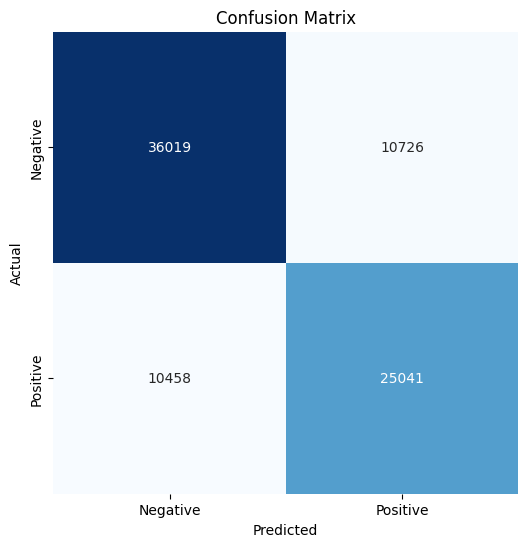

In [34]:
# 혼동 행렬을 계산합니다.
cm = confusion_matrix(y_test, y_pred_dt)

# 혼동 행렬을 시각화합니다.
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## AUC ROC Curve

In [ ]:
# 테스트 데이터에 대한 예측 확률을 얻음
y_score = xgb_classifier.predict_proba(X_test_scaled)[:, 1]

# ROC 곡선 계산
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Feature importance

In [207]:
feature_names = df_x_train.columns.tolist()

In [208]:
feature_importance = rf_classifier.feature_importances_

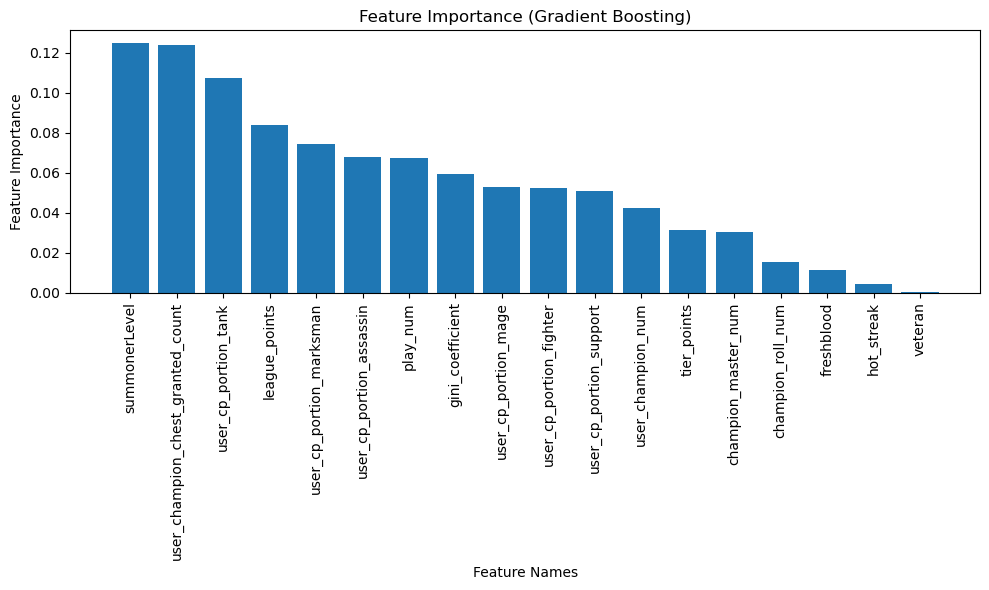

In [209]:
# 변수 중요도를 기준으로 내림차순 정렬
sorted_idx = np.argsort(feature_importance)[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_idx]
sorted_feature_importance = [feature_importance[i] for i in sorted_idx]

# 변수 중요도를 시각화
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_feature_importance)), sorted_feature_importance, align='center')
plt.xticks(range(len(sorted_feature_importance)), sorted_feature_names, rotation=90)
plt.xlabel('Feature Names')
plt.ylabel('Feature Importance')
plt.title('Feature Importance (Gradient Boosting)')
plt.tight_layout()
plt.show()

## Frequency analysis

In [52]:
day_list.sort()

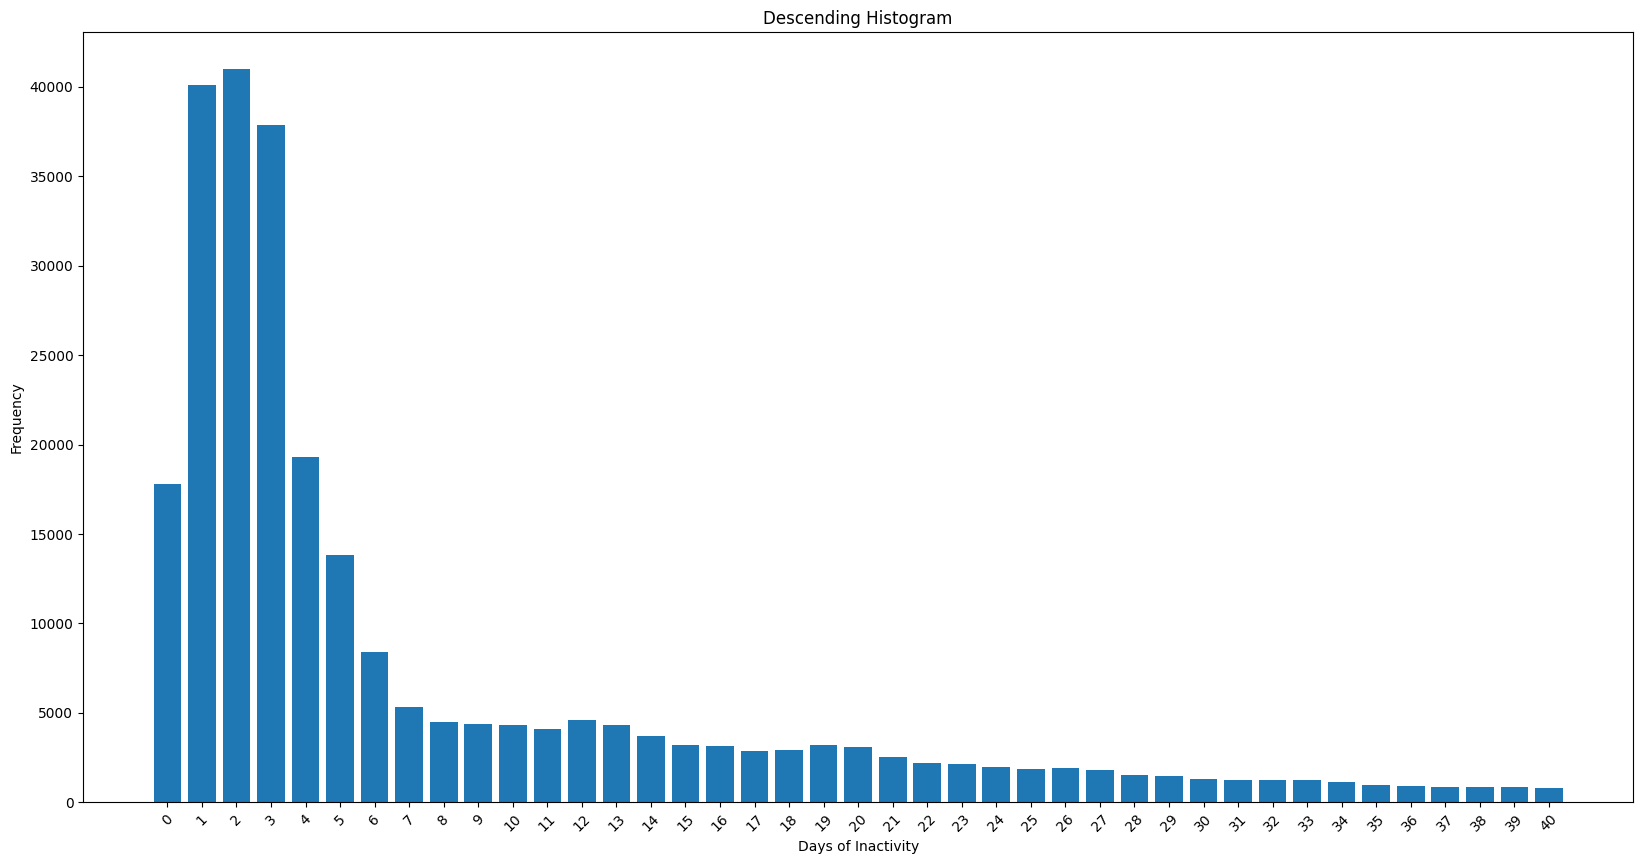

In [45]:
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

# 각 숫자의 빈도를 계산
counter = Counter(day_list)

# x축과 y축 데이터 생성
x_values = list(counter.keys())
y_values = [counter[x_value] for x_value in x_values]

# 표시할 눈금 범위 설정
start_x = 0  # 시작 범위 설정
end_x = 40  # 원하는 끝 범위 설정

# 데이터프레임 생성
df = pd.DataFrame({'Values': x_values, 'Frequency': y_values})

# 데이터프레임을 내림차순으로 정렬
df = df.sort_values(by='Frequency', ascending=False)

# 그래프 크기 조절 (가로 크기를 크게, 세로 크기를 크게 설정)
plt.figure(figsize=(20, 10)) 

# 막대 그래프 그리기
plt.bar(df['Values'][:end_x + 1], df['Frequency'][:end_x + 1])  # x축 눈금 범위만큼 데이터 출력
plt.xlabel('Days of Inactivity')
plt.ylabel('Frequency')
plt.title('Descending Histogram')

# x축 눈금 설정
plt.xticks(range(start_x, end_x + 1), rotation=45)
plt.show()

## 접속기록 빈도

In [110]:
# 리스트의 요소를 카운트하여 딕셔너리로 저장
count_dict = {}
for item in day_list:
    if item in count_dict:
        count_dict[item] += 1
    else:
        count_dict[item] = 1

# 딕셔너리를 데이터프레임으로 변환
df = pd.DataFrame(list(count_dict.items()), columns=["접속일수", "카운트"])

# 데이터프레임 출력
print(df)

      접속일수    카운트
0     10.0   4302
1      1.0  40098
2     15.0   3230
3      6.0   8424
4      2.0  41001
..     ...    ...
130  130.0      1
131  113.0      4
132  133.0      1
133  129.0      2
134  132.0      1

[135 rows x 2 columns]


In [112]:
df = df.sort_values(by='접속일수')
df['비율'] = 100 * (df['카운트'] / df['카운트'].sum())
df.reset_index(inplace = True)

In [118]:
df.iloc[:20]

,index,접속일수,카운트,비율
0,57,0.0,17785,6.487443
1,1,1.0,40098,14.626566
2,4,2.0,41001,14.955954
3,7,3.0,37856,13.808751
4,5,4.0,19327,7.049919
5,6,5.0,13823,5.042222
6,3,6.0,8424,3.072826
7,17,7.0,5352,1.952252
8,16,8.0,4476,1.632713
9,20,9.0,4375,1.595871


In [119]:
df.iloc[20:40]

,index,접속일수,카운트,비율
20,8,20.0,3083,1.124587
21,13,21.0,2539,0.926152
22,26,22.0,2169,0.791187
23,31,23.0,2141,0.780974
24,38,24.0,1948,0.710573
25,39,25.0,1836,0.669719
26,37,26.0,1925,0.702183
27,10,27.0,1784,0.650751
28,32,28.0,1522,0.555181
29,34,29.0,1443,0.526364


## 모델 저장

In [52]:
import joblib

# 모델을 저장할 파일 경로
model_filename = 'my_model.pkl'

# 모델 저장
joblib.dump(your_model, model_filename)

# 저장한 모델 불러오기
loaded_model = joblib.load(model_filename)

89613    0
22236    0
23210    0
55323    0
17756    0
        ..
58548    0
35048    0
8161     0
67261    0
18923    0
Name: leave_game, Length: 73170, dtype: int32

In [53]:
df_x_1 = df_1[['play_num', 'veteran', 'hot_streak', 'freshblood', 'league_points', 'tier_points', 'summonerLevel',
                 'user_champion_chest_granted_count', 'user_cp_portion_assassin', 
                     'user_cp_portion_fighter','user_cp_portion_mage', 'user_cp_portion_marksman','user_cp_portion_support', 'user_cp_portion_tank','champion_master_num',
       'user_champion_num', 'days_diff']]

df_x_2 = df_2[['play_num', 'veteran', 'hot_streak', 'freshblood', 'league_points', 'tier_points', 'summonerLevel',
                 'user_champion_chest_granted_count', 'user_cp_portion_assassin', 
                     'user_cp_portion_fighter','user_cp_portion_mage', 'user_cp_portion_marksman','user_cp_portion_support', 'user_cp_portion_tank','champion_master_num',
       'user_champion_num', 'days_diff']]

df_x_3 = df_3[['play_num', 'veteran', 'hot_streak', 'freshblood', 'league_points', 'tier_points', 'summonerLevel',
                 'user_champion_chest_granted_count', 'user_cp_portion_assassin', 
                     'user_cp_portion_fighter','user_cp_portion_mage', 'user_cp_portion_marksman','user_cp_portion_support', 'user_cp_portion_tank','champion_master_num',
       'user_champion_num', 'days_diff']]

df_x_4 = df_extra[['play_num', 'veteran', 'hot_streak', 'freshblood', 'league_points', 'tier_points', 'summonerLevel',
                 'user_champion_chest_granted_count', 'user_cp_portion_assassin', 
                     'user_cp_portion_fighter','user_cp_portion_mage', 'user_cp_portion_marksman','user_cp_portion_support', 'user_cp_portion_tank','champion_master_num',
       'user_champion_num', 'days_diff']]

df_x_5 = df_extra_2[['play_num', 'veteran', 'hot_streak', 'freshblood', 'league_points', 'tier_points', 'summonerLevel',
                 'user_champion_chest_granted_count', 'user_cp_portion_assassin', 
                     'user_cp_portion_fighter','user_cp_portion_mage', 'user_cp_portion_marksman','user_cp_portion_support', 'user_cp_portion_tank','champion_master_num',
       'user_champion_num', 'days_diff']]

In [54]:

df_x_4['tier_points'] = df_x_4['tier_points'].round()
df_x_4['play_num'] = df_x_4['play_num'].round()
df_x_4['league_points'] = df_x_4['league_points'].round()
df_x_4['summonerLevel'] = df_x_4['summonerLevel'].round()
df_x_4['user_champion_chest_granted_count'] = df_x_4['user_champion_chest_granted_count'].round()
df_x_4['days_diff'] = df_x_4['days_diff'].round()
df_x_4['champion_master_num'] = df_x_4['champion_master_num'].round()
df_x_4['user_champion_num'] = df_x_4['user_champion_num'].round()

df_x_5['tier_points'] = df_x_5['tier_points'].round()
df_x_5['play_num'] = df_x_5['play_num'].round()
df_x_5['league_points'] = df_x_5['league_points'].round()
df_x_5['summonerLevel'] = df_x_5['summonerLevel'].round()
df_x_5['user_champion_chest_granted_count'] = df_x_5['user_champion_chest_granted_count'].round()
df_x_5['days_diff'] = df_x_5['days_diff'].round()
df_x_5['champion_master_num'] = df_x_5['champion_master_num'].round()
df_x_5['user_champion_num'] = df_x_5['user_champion_num'].round()

In [55]:
df = pd.concat([df_x_1, df_x_2, df_x_3, df_x_4, df_x_5], axis = 0)

In [61]:
df.columns

Index(['play_num', 'veteran', 'hot_streak', 'freshblood', 'league_points',
       'tier_points', 'summonerLevel', 'user_champion_chest_granted_count',
       'user_cp_portion_assassin', 'user_cp_portion_fighter',
       'user_cp_portion_mage', 'user_cp_portion_marksman',
       'user_cp_portion_support', 'user_cp_portion_tank',
       'champion_master_num', 'user_champion_num', 'days_diff',
       'gini_coefficient'],
      dtype='object')

In [57]:
selected_cols = [
    'user_cp_portion_mage', 'user_cp_portion_marksman', 'user_cp_portion_tank',
    'user_cp_portion_fighter', 'user_cp_portion_assassin', 'user_cp_portion_support'
]

df['gini_coefficient'] = df[selected_cols].apply(calculate_gini, axis=1)

In [58]:
df.loc[df['user_champion_num'] < 0, 'user_champion_num'] = 1

In [59]:
df.loc[df['gini_coefficient'] < 0, 'gini_coefficient'] = 0

In [62]:
df_x_train['champion_roll_num'].value_counts()

champion_roll_num
4.0    104517
5.0     98210
3.0     58820
6.0      9521
2.0      2987
1.0        90
Name: count, dtype: int64

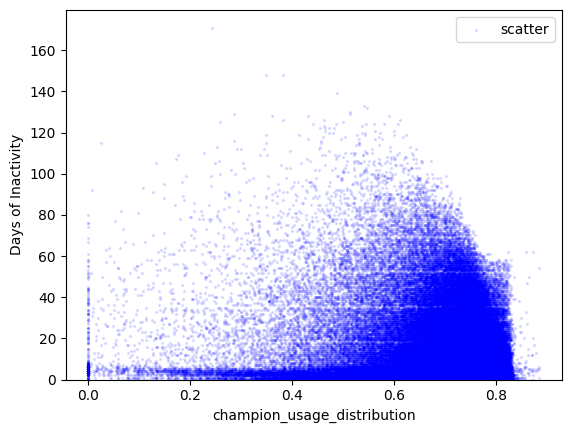

In [86]:
x_ticks = df['gini_coefficient']
y_ticks = df['days_diff']

plt.scatter(x_ticks, y_ticks, color = 'blue', marker='o', label = 'scatter', alpha = 0.1, s = 2)

plt.ylim(0, )
plt.legend()
plt.xlabel('champion_usage_distribution')
plt.ylabel('Days of Inactivity')

plt.show()

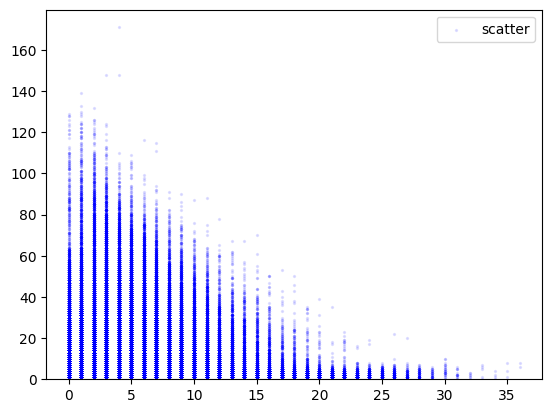

In [123]:
x_ticks = df['user_champion_chest_granted_count']
y_ticks = df['days_diff']

plt.scatter(x_ticks, y_ticks, color = 'blue', marker='o', label = 'scatter', alpha = 0.1, s = 2)

plt.ylim(0, )
plt.legend()

plt.show()